In [0]:
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
%matplotlib inline

In [0]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
data = read_data_sets("data", one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels))) # here "\t" is for tab
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

In [0]:
batch = data.train.next_batch(10)

In [0]:
np.shape(batch[1])

(10, 10)

In [0]:
# Function for declaring weight variable
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
# Here "tf.truncated_normal" function returns the graph random values from a truncated normal distribution with a given standard deviation
# and "tf.Variable" fucntion returns the graph of variables, Here 

In [0]:
# Function for declaring Bias variable
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [0]:
def new_encod_layer(input,             # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter(or weights).
                   num_filters,        # Number of filters./ or ouput channel
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    # The convolutional layer
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    # Add the biases to the results of the convolution.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights


In [0]:
def new_decod_layer(input,             # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter(or weights)
                   num_filters,        # Number of filters./ No of output channel
                   upsample_size,      # Upsampling size
                   use_upsampling=True):

  
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)
   
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
   
    if use_upsampling:
        Upsam=tf.image.resize_images(input, size=(upsample_size,upsample_size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        
    layer = tf.nn.conv2d(input=Upsam,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    layer = tf.nn.relu(layer)
   
    return layer, weights


In [0]:
def Logits_layer(input,               # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter(or weights).
                   num_filters):      # Number of filters./ or ouput channel

    shape = [filter_size, filter_size, num_input_channels, num_filters]

 
    weights = new_weights(shape=shape)

  
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    return layer, weights

In [0]:
input_image = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets') # Original image without noise to evaluate the gradient

In [0]:
#First Encoder
#The input has a dimention of 28x28x1
E1, WE1 = new_encod_layer(input=input_image, 
                         num_input_channels=1,# Because input image is gray
                         filter_size=10, # the weight matrix will be of size 10x10
                         num_filters=10, # Number of output channel will be 10
                         use_pooling=True)
#output of the convolutional layer is 14x14x10 since the function max pool and stride at 2x2

In [0]:
#2nd Encoder
#The input has a dimention of 14x14x10
E2, WE2 = new_encod_layer(input=E1, 
                         num_input_channels=10,
                         filter_size=5, # the weight matrix will be of size 10x10
                         num_filters=10, # No of output channel will be 10
                         use_pooling=True)
#output of the convolutional layer is of 7x7x10 since the function max pool and stride at 2x2

In [0]:
# First Decoder
# The input has a dimention of 7X7X10

D1, WD1 = new_decod_layer(input=E2,       # The previous layer.
                   num_input_channels=10, # Num. channels in prev. layer.
                   filter_size=5,         # Width and height of each filter(or weights)
                   num_filters=10,        # Number of filters./ No of output channel
                   upsample_size=14,      # Upsampling size
                   use_upsampling=True) 
#output of the convolutional layer is of 14x14x10 since the function has 14x14 upsampling

In [0]:
# 2nd Decoder
# The input has a dimention of 14X14X10

D2, WD2 = new_decod_layer(input=D1,       # The previous layer.
                   num_input_channels=10, # Num. channels in prev. layer.
                   filter_size=10,         # Width and height of each filter(or weights)
                   num_filters=10,        # Number of filters./ No of output channel
                   upsample_size=28,      # Upsampling size
                   use_upsampling=True) 
#output of the convolutional layer is of 28x28x10 since the function has 14x14 upsampling

In [0]:
# The input layer(D2) have a dimention of 28x28x10
Logits_Layer_1, Logits_weights = Logits_layer(input=D2,              # The previous layer.
                                              num_input_channels=10, # Num. channels in prev.(input) layer.
                                              filter_size=10,        # Width and height of each filter(or weights).
                                              num_filters=1)       # Number of filters./ or ouput channel

In [0]:
# Pass the Loggits through sigmoid to get the reconstructed  image
Reconstructed_Image = tf.nn.sigmoid(Logits_Layer_1)

In [0]:
# Generating the loss: 

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=Logits_Layer_1)
#loss = tf.nn.softmax_cross_entropy_with_logits(labels=targets_, logits=Logits_Layer_1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Design of Optimization method
learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)

opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
#opt = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [0]:
sess = tf.Session()
epochs = 1
batch_size = 5
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.7 # noise factor is in between 0 and 1. 0 is less and 1 is high
sess.run(tf.global_variables_initializer())

# Parameters for determining dynamic learning rate
max_learning_rate = 0.001
min_learning_rate = 0.0001
decay_speed = 2000.0



for e in range(epochs):
    for ii in range(data.train.num_examples//batch_size): # Rounded division
        lr= min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-ii/decay_speed)
        
        batch = data.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={input_image: noisy_imgs,targets_: imgs,learning_rate:lr})
        print("Epoch: {}/{}...".format(e+1, epochs),"Training loss: {:.4f}".format(batch_cost))

In [0]:
def Test_model(batch_size):
    n=batch_size
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_noisy = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch,_  = data.test.next_batch(n)
    
        imgs = batch.reshape((-1, 28, 28, 1)) #original batch of test image
        #noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        noisy_imgs = imgs + 0.5 * np.random.randn(*imgs.shape)
        # Clip the pixel values of the image in between 0.0 and 1.0
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Reconstruct the noisy image through the trined model(Encode and decode)
        FIm=sess.run(Reconstructed_Image,feed_dict={input_image: noisy_imgs})

        # Display original images
        for j in range(n):
            # Draw the original digit images
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch[j].reshape([28, 28])
        #Display noisy image
        for j in range(n):
            # Draw the noisy digit images
            canvas_noisy[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = noisy_imgs[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digit images
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = FIm[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.axis('off')
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Noisy Images with noise factor of 0.5 as input")
    plt.figure(figsize=(n, n))
    plt.axis('off')
    plt.imshow(canvas_noisy, origin="upper", cmap="gray")
    plt.show()
    
    print("Reconstructed Images from the noisy images")
    plt.figure(figsize=(n, n))
    plt.axis('off')
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

Original Images


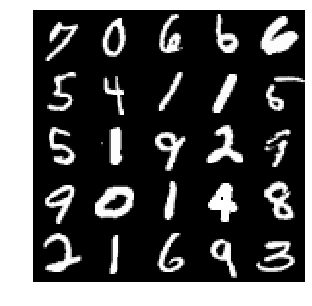

Noisy Images with noise factor of 0.5 as input


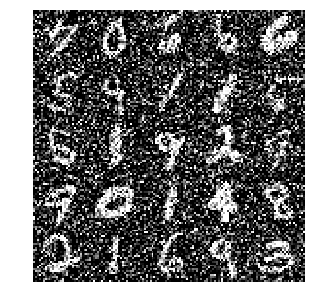

Reconstructed Images from the noisy images


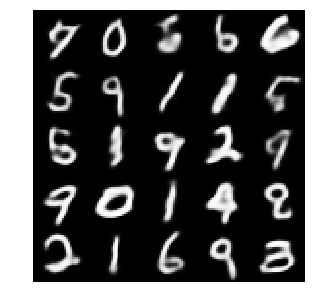

In [0]:
Test_model(batch_size=5)